In [ ]:
# ================================================================
# 1. 라이브러리 임포트
# ================================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score

# ================================================================
# 2. 데이터 로드
# ================================================================
train = pd.read_csv("../data/processed/train_sliding.csv")
test = pd.read_csv("../data/processed/test_sliding.csv")

print(" Train shape:", train.shape)
print(" Test shape:", test.shape)

# ================================================================
# 3. Feature / Target 분리
# ================================================================
drop_cols = ['num', 'base_ym', 'target_ym', 'open', 'y']

X = train.drop(columns=drop_cols)
y = train['y']

# 모든 feature가 숫자인지 확인
print("\n[Feature dtype check]")
print(X.dtypes.value_counts())

### 1. XGBoost 중요도

In [27]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
xgb.fit(X, y)

imp = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb.feature_importances_
}).sort_values(by='importance', ascending=False)

imp['cum_ratio'] = imp['importance'].cumsum() / imp['importance'].sum()


In [28]:
# 누적 중요도 90%
xgb_top = imp[imp['cum_ratio'] <= 0.9]['feature'].tolist()
print(f"[XGB] 누적 중요도 90% 내 변수 수: {len(xgb_top)}")

[XGB] 누적 중요도 90% 내 변수 수: 56


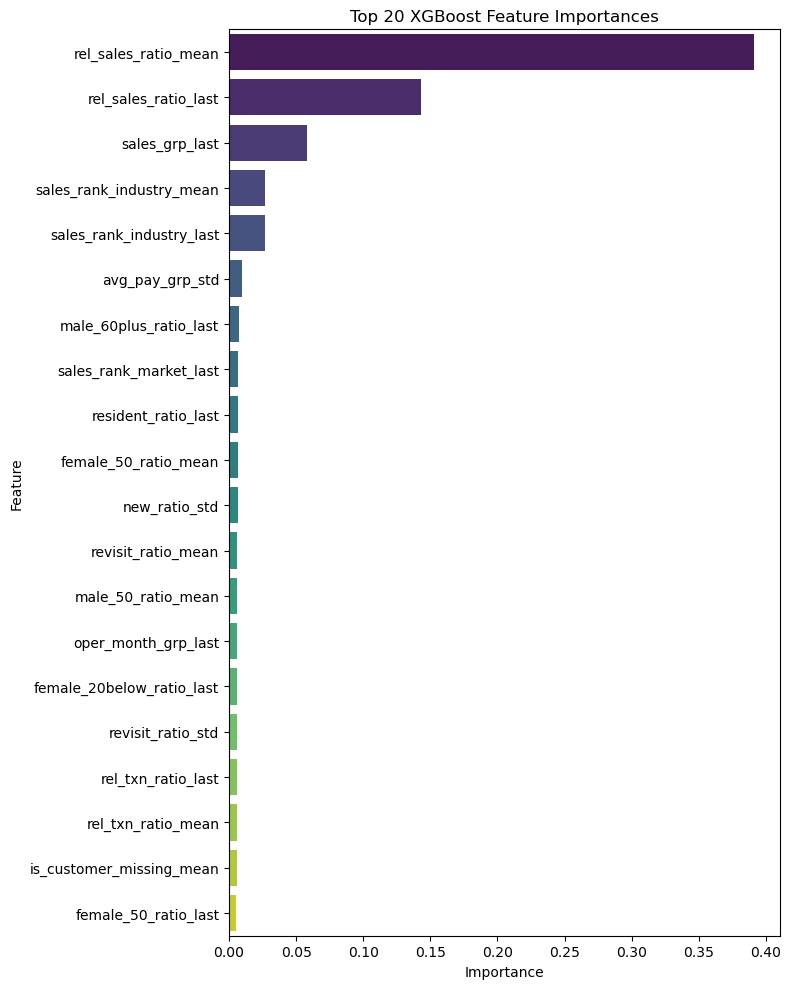

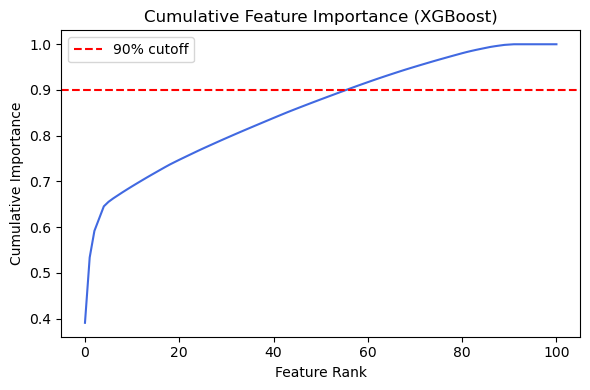

In [36]:
# --- 시각화: XGB 변수 중요도 상위 20개 ---
plt.figure(figsize=(8,10))
sns.barplot(data=imp.head(20), x='importance', y='feature', palette='viridis')
plt.title("Top 20 XGBoost Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- 시각화: 누적 중요도 곡선 ---
plt.figure(figsize=(6,4))
plt.plot(np.arange(len(imp)), imp['cum_ratio'], color='royalblue')
plt.axhline(0.9, color='red', linestyle='--', label='90% cutoff')
plt.title("Cumulative Feature Importance (XGBoost)")
plt.xlabel("Feature Rank")
plt.ylabel("Cumulative Importance")
plt.legend()
plt.tight_layout()
plt.show()


### 2. LassoCV

In [29]:
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

lasso = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    LassoCV(cv=5, random_state=42)
)
lasso.fit(X, y)

lasso_coef = pd.DataFrame({
    'feature': X.columns,
    'coef': lasso.named_steps['lassocv'].coef_
})
lasso_top = lasso_coef[lasso_coef['coef'] != 0]['feature'].tolist()
print(f"[Lasso] 비제로(유효) 변수 수: {len(lasso_top)}")


[Lasso] 비제로(유효) 변수 수: 55


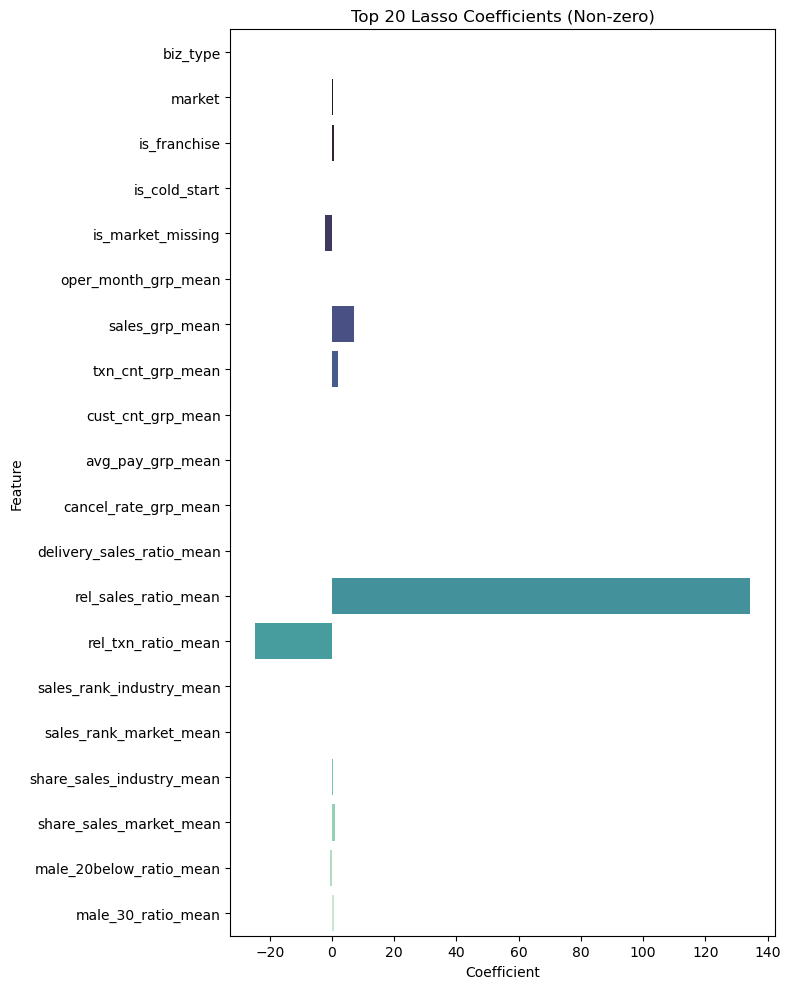

In [37]:
plt.figure(figsize=(8,10))
sns.barplot(data=lasso_coef.head(20), x='coef', y='feature', palette='mako')
plt.title("Top 20 Lasso Coefficients (Non-zero)")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### 3. XGBoost ∪ Lasso 교집합

In [35]:
final_features = sorted(list(set(xgb_top) & set(lasso_top)))
print(f"[최종 후보 변수 수] {len(final_features)}개")
print(final_features)

[최종 후보 변수 수] 31개
['avg_pay_grp_std', 'cancel_rate_grp_std', 'cust_cnt_grp_last', 'female_20below_ratio_mean', 'female_50_ratio_last', 'female_50_ratio_std', 'female_60plus_ratio_std', 'is_customer_missing_mean', 'male_30_ratio_std', 'male_50_ratio_mean', 'male_50_ratio_std', 'male_60plus_ratio_last', 'male_60plus_ratio_mean', 'new_ratio_mean', 'rel_sales_ratio_last', 'rel_sales_ratio_mean', 'rel_txn_ratio_last', 'rel_txn_ratio_mean', 'resident_ratio_mean', 'revisit_ratio_last', 'revisit_ratio_std', 'sales_grp_std', 'sales_rank_industry_last', 'sales_rank_industry_std', 'sales_rank_market_last', 'sales_rank_market_std', 'share_sales_industry_mean', 'share_sales_industry_std', 'share_sales_market_mean', 'share_sales_market_std', 'txn_cnt_grp_std']


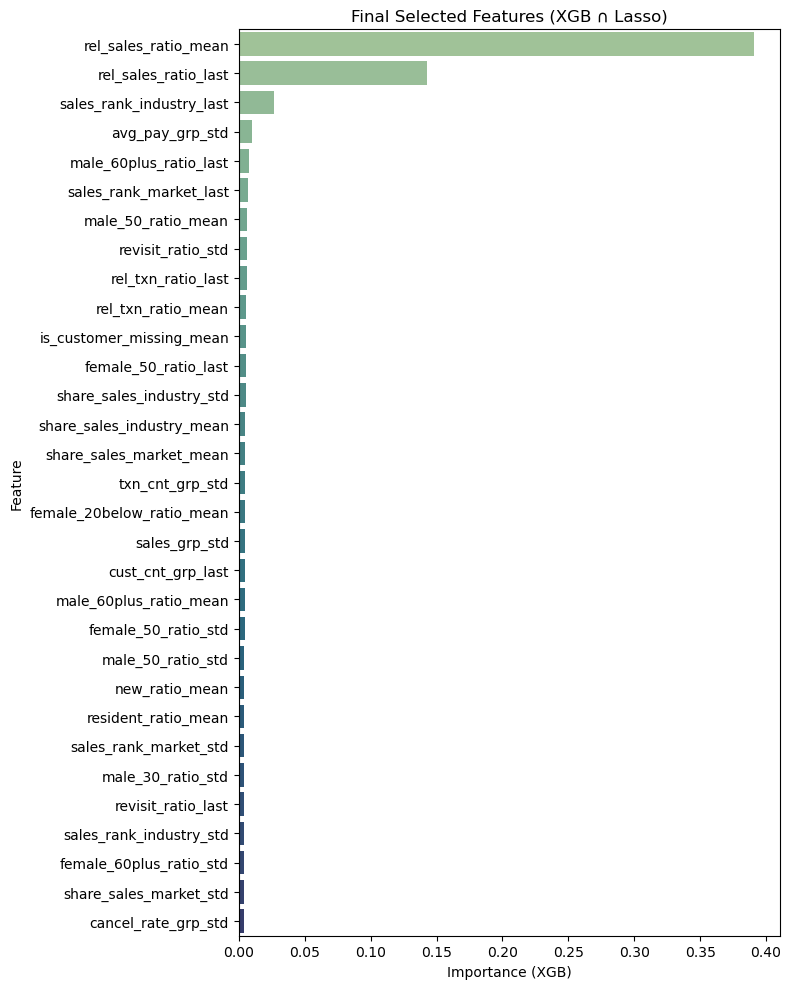

In [38]:
imp_final = imp[imp['feature'].isin(final_features)]
plt.figure(figsize=(8,10))
sns.barplot(data=imp_final.sort_values('importance', ascending=False),
            x='importance', y='feature', palette='crest')
plt.title("Final Selected Features (XGB ∩ Lasso)")
plt.xlabel("Importance (XGB)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [39]:
# 내보내기
import joblib

# final_features 저장
joblib.dump(final_features, "../data/processed/final_features.pkl")

['../data/processed/final_features.pkl']